In [ ]:
# Installing the necessary libraries
!pip install numpy scipy networkx matplotlib powerlaw networkit python-louvain scikit-learn

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import sys
import math
import random
import sklearn
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx

from collections import deque
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import ranksums
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



#-------------------------------------------------------------------------------
#----------------------------FUNCTIONS------------------------------------------

# Degree Centrality (degree of a node) calculations

def degrees(adjacency_matrix):
  DC_values = np.sum(adjacency_matrix, axis=1)
  return DC_values

#-------------------------------------------------------------------------------

# Betweenness Centrality calculations (via Ulrik Brandes algorithm)

  # OBS: Outputs both the vertex centrality and the edge betweenness centrality

def betweenness_centrality(adjacency_matrix):

  size = adjacency_matrix.shape[0]
  A = adjacency_matrix.copy()
  Q = deque()
  S = []
  BC_values = [0]*size
  EBC_values = {(i, j): 0.0 for i in range(size) for j in range(size)}


  for s in range(size):

    #---------------------SSSP Problem----------------------------

    # Create a list of lists with the predecessors of each vertex
    P = [[] for _ in range(size)]
    # Create a list with the distances of shortest paths from node s to t
    d = [-1]*size
    d[s] = 0
    # Create a list with the numbers of shortest paths from node s to t
    sigma = [0]*size
    sigma[s] = 1
    Q.append(s)

    while Q:
      v = Q.popleft()
      S.append(v)

      neighbours = np.nonzero(A[v])[0]

      for w in neighbours:
        # w found for the first time?
        if (d[w] < 0) :
          d[w] = d[v] + 1
          Q.append(w)
        # Shortest path from w via v?
        if (d[w] == d[v] + 1) :
          sigma[w] = sigma[w] + sigma[v]
          P[w].append(v)

    #-------------------------Accumulation--------------------------------------

    # Create a list of dependencies from s including node v
    delta = [0]*size
    while S:
      w = S.pop()
      for v in P[w]:
        c = (sigma[v]/sigma[w])*(1+delta[w])
        EBC_values[(v,w)] = EBC_values[(v,w)] + c
        delta[v] = delta[v] + c
        if w != s:
          BC_values[w] = BC_values[w] + delta[w]

    #---------------------------------------------------------------------------

  return BC_values, EBC_values

#------------------------------------------------------------------------------

# Nodal Clustering Coefficient calculations

def nodal_clustering_coefficients(adjacency_matrix):

  size = adjacency_matrix.shape[0]
  local_clustering_coefficients = []

  for i in range(size):
    neighbours = np.nonzero(adjacency_matrix[i])[0]
    neighbourhood_size = len(neighbours)

    # Exception for a node that has degree 1
    if (neighbourhood_size < 2):
      frac = 0
      local_clustering_coefficients.append(frac)
      continue

    numerator = 0
    denominator = (neighbourhood_size*(neighbourhood_size-1))/2

    for node in neighbours:
      for other_node in neighbours:
        if (node < other_node) and (adjacency_matrix[node][other_node] == 1):
          numerator+=1

    frac = numerator/denominator

    local_clustering_coefficients.append(frac)

  return local_clustering_coefficients

#-------------------------------------------------------------------------------

# Eigenvector Centrality calculation (via power iteration method)

def eigenvector_centrality(adjacency_matrix, max_iter=1000, tol=1e-6):

    # Initialize the eigenvector centrality vector
    n = adjacency_matrix.shape[0]
    centrality = np.ones(n)

    # Power iteration method to find the principal eigenvector
    for i in range(max_iter):
        centrality_next = np.dot(adjacency_matrix, centrality)

        # Normalize the eigenvector
        centrality_next /= np.linalg.norm(centrality_next, 2)

        # Check for convergence
        if np.linalg.norm(centrality_next - centrality, 2) < tol:
            break

        centrality = centrality_next

    return centrality

#-------------------------------------------------------------------------------

# Function to calculate metrics for an adjacency matrix

def calculate_metrics(adjacency_matrix):

    # Calculate the entropy of the desired metrics (using the minimum)
    DC = degrees(adjacency_matrix)
    DC = np.min(DC)

    BC = betweenness_centrality(adjacency_matrix)[0]
    BC = np.min(BC)

    CC = nodal_clustering_coefficients(adjacency_matrix)
    CC = np.min(CC)

    EC = eigenvector_centrality(adjacency_matrix)
    EC = np.min(EC)

    return {
        'min_DC': DC,
        'min_BC': BC,
        'min_CC': CC,
        'min_EC': EC
    }

#-------------------------------------------------------------------------------

In [ ]:
# Data Pipeline

# Define the dataset directory path
main_directory = '/content/drive/My Drive/ABIDE/abide'

# List all folders in the main directory
folders_list = os.listdir(main_directory)

# Create a list containing all folder
folders = []
for folder in folders_list:
  folders.append(folder)

folders = sorted(folders)
folders.remove('.DS_Store')

# Initialize lists to store data for CSV
patient_names = []
class_labels = []

# Initialize the metrics_data dictionary outside the loop
metric_keys = ['min_DC','min_BC','min_CC','min_EC']
metrics_data = {metric_name: [] for metric_name in metric_keys}

# Iterate through folders
i=0
for f in folders:
  print(i+1)

  file_path = main_directory + '/' + f + '/' + f + '_harvard48_correlation_matrix.mat'

  # Load the MAT file
  mat_file = scipy.io.loadmat(file_path)

  # Accessing data
  data = mat_file.get('data')

  # Exclude diagonal entries (self-loops)
  np.fill_diagonal(data, 0)

  # Take the absolute value of the correlations
  abs_correlations = np.abs(data)

  # Flatten the matrix into 1D array
  flattened_correlations = abs_correlations.flatten()

  # Find the 80th percentile
  percentile_80 = np.percentile(flattened_correlations, 80)

  # Binarize the matrix based on the 80th percentile
  binary_matrix = (abs_correlations >= percentile_80).astype(int)

  # Create a numpy array containing the adjacency matrix
  A = binary_matrix

  # Identify the name of the patient and the class
  patient_name = f

  if "control" in patient_name:
    class_label = "control"
  elif "patient" in patient_name:
    class_label = "patient"

  # Append the current name of the patient to the list
  patient_names.append(patient_name)

  # Append the current class label to the list
  class_labels.append(class_label)

  # Calculate metrics for the adjacency matrix
  metrics = calculate_metrics(A)
  # metrics_data = {metric_name: [] for metric_name in metrics.keys()}

  # Append data to lists
  for metric_name, metric_value in metrics.items():
    metrics_data[metric_name].append(metric_value)

  i+=1

print("Length of patient_names:", len(patient_names))
print("Length of class_labels:", len(class_labels))
for metric_name, metric_values in metrics_data.items():
    print(f"Length of {metric_name}:", len(metric_values))

# Create a DataFrame
data = {'Patient': patient_names, 'Class': class_labels, **metrics_data}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
google_drive_path = '/content/drive/My Drive/ABIDE/min_80th.csv'
df.to_csv(google_drive_path, index=False)

SystemExit: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


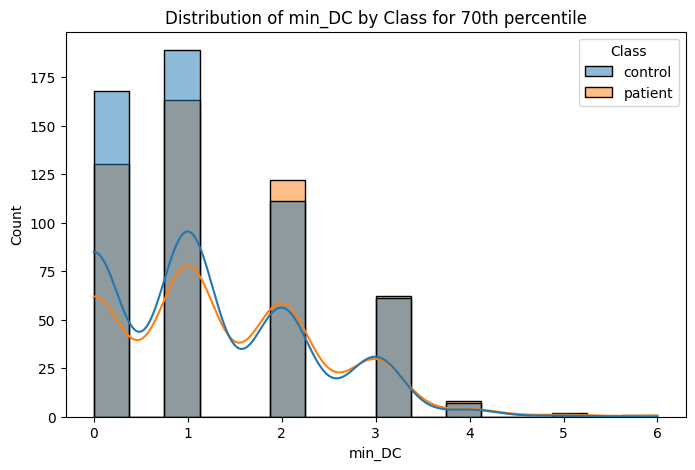

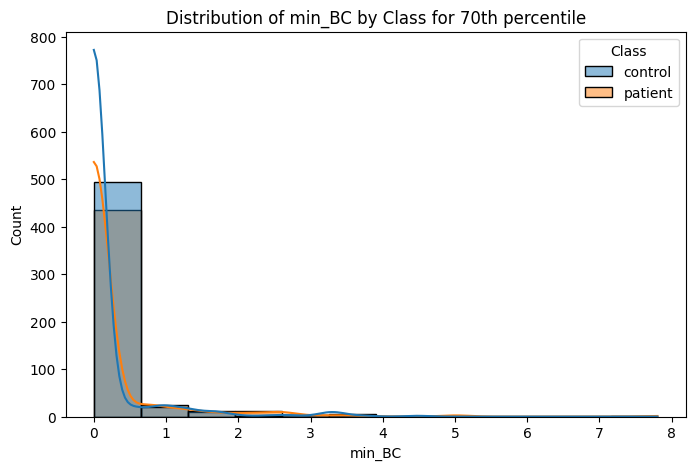

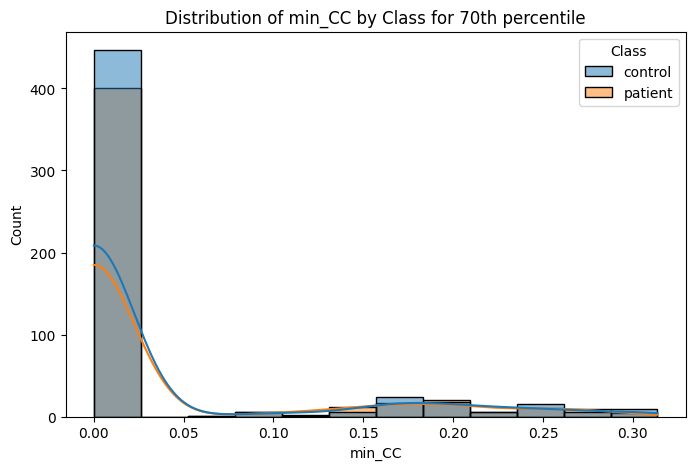

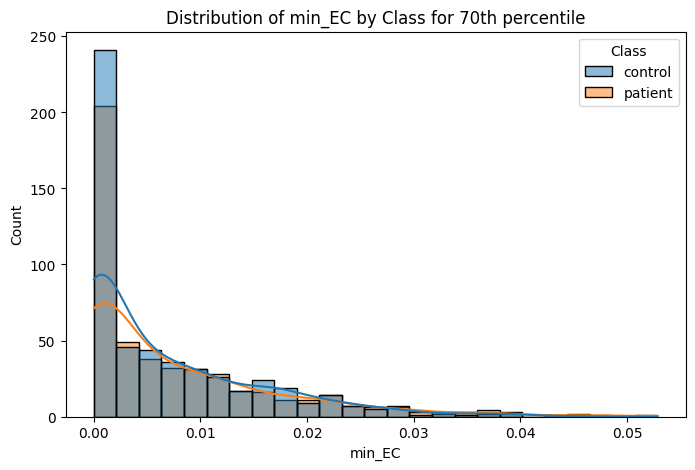

In [9]:
# Statistical analysis

# Read the .csv file
google_drive_path = '/content/drive/My Drive/ABIDE/min_80th.csv'
df = pd.read_csv(google_drive_path)

# Plot distributions for each attribute separated by class
for column in df.columns[2:]:  # Exclude the 'Class' column
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column, hue='Class', kde=True)
    plt.title(f'Distribution of {column} by Class for 70th percentile')
    # Save the figure
    percentile = str(80)
    file_label = column
    img_name = percentile + 'th_' + file_label + '_plot'
    plt.savefig('/content/drive/My Drive/ABIDE/' + img_name + '.png')
    #plt.show()

# Set the column labels
name_column = 'Patient'
class_column = 'Class'

# Get a list of all attribute columns
attribute_columns = df.columns[(df.columns != class_column) & (df.columns != name_column)]

# Convert data types to numeric
df[attribute_columns] = df[attribute_columns].apply(pd.to_numeric, errors='coerce')

# Perform t-test for each attribute
for attribute_column in attribute_columns:

    control_data = df[df[class_column] == 'control'][attribute_column]
    patient_data = df[df[class_column] == 'patient'][attribute_column]

    t_stat, p_value = ttest_ind(control_data, patient_data)


    # Print the results for each attribute
    # print(f'T-test for {attribute_column}: T-statistic={t_stat}, p-value={p_value}')

# Save descriptive statistics to CSV
df_describe.to_csv('/content/drive/My Drive/ABIDE/min_80th_t_test_descriptive_statistics.csv')

# Save t-test results to CSV
t_test_results = []

for attribute_column in attribute_columns:
    control_data = df[df[class_column] == 'control'][attribute_column]
    patient_data = df[df[class_column] == 'patient'][attribute_column]

    t_stat, p_value = ttest_ind(control_data, patient_data)

    # Append results to the list
    t_test_results.append({
        'Attribute': attribute_column,
        'T-statistic': t_stat,
        'P-value': p_value
    })

# Convert the list to a DataFrame
df_t_test_results = pd.DataFrame(t_test_results)

# Save t-test results to CSV
df_t_test_results.to_csv('/content/drive/My Drive/ABIDE/min_80th_t_test_results.csv', index=False)


In [ ]:
# Statistical analysis part 2 (what if the distributions are not gaussian?)

# Initialize an empty list for results
mann_whitney_results = []

label_list = ['min_DC', 'min_BC', 'min_CC', 'min_EC']

for L in label_list:

    list_control = []
    list_patient = []

    # Iterate over rows
    for index, row in df.iterrows():
        if row['Class'] == 'control':
            list_control.append(row[L])
        elif row['Class'] == 'patient':
            list_patient.append(row[L])

    # Perform Mann-Whitney U test
    statistic, p_value = mannwhitneyu(list_control, list_patient)

    # Interpret the results
    significance = "Significant" if p_value < 0.05 else "Not Significant"

    # Append results to the list
    mann_whitney_results.append({
        'Label': L,
        'Statistic': statistic,
        'P-Value': p_value,
        'Significance': significance
    })

# Convert the list to a DataFrame
df_mann_whitney_results = pd.DataFrame(mann_whitney_results)

# Save Mann-Whitney U test results to CSV with labels, statistics, p-values, and significance
df_mann_whitney_results.to_csv('/content/drive/My Drive/ABIDE/min_80th_mann_whitney_results.csv', index=False)



In [ ]:
# Statistical analysis part 3 (another non-parametric test)

# Initialize an empty list for results
wilcoxon_results = []

label_list = ['min_DC', 'min_BC', 'min_CC', 'min_EC']

for L in label_list:

    list_control = []
    list_patient = []

    # Iterate over rows
    for index, row in df.iterrows():
        if row['Class'] == 'control':
            list_control.append(row[L])
        elif row['Class'] == 'patient':
            list_patient.append(row[L])

    # Perform Mann-Whitney U test
    statistic, p_value = ranksums(list_control, list_patient)

    # Interpret the results
    significance = "Significant" if p_value < 0.05 else "Not Significant"

    # Append results to the list
    wilcoxon_results.append({
        'Label': L,
        'Statistic': statistic,
        'P-Value': p_value,
        'Significance': significance
    })

# Convert the list to a DataFrame
df_wilcoxon_results = pd.DataFrame(wilcoxon_results)

# Save Mann-Whitney U test results to CSV with labels, statistics, p-values, and significance
df_wilcoxon_results.to_csv('/content/drive/My Drive/ABIDE/wilcoxon_results_80th.csv', index=False)

In [ ]:
# Classification step

# K-NN implementation

# Assuming 'Class' is the column with strings like 'control' or 'patient'
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])

# Define Features and Target Variable
X = df.iloc[:, 2]
X = X.values.reshape(-1, 1)
y = df['Class']

# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

best_accuracy = 0
best_k_value = 1

# Initialize and Train the k-NN Classifier
for k in range(1, 100):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)

    # Make Predictions
    y_pred = knn_classifier.predict(X_test)

    # Decode the numerical predictions back to original labels
    y_pred_original_labels = label_encoder.inverse_transform(y_pred)

    # Evaluate the Model
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k_value = k
        best_confusion_matrix = confusion_matrix(y_test, y_pred)

# Create a dictionary to store the metrics
metrics_dict = {
    'best k-value': best_k_value,
    'accuracy': best_accuracy,
    'confusion matrix': best_confusion_matrix
}

# Convert the dictionary to a DataFrame
report_df = pd.DataFrame([metrics_dict])

# Save the DataFrame to a CSV file
report_df.to_csv('/content/drive/My Drive/ABIDE/min_80th_classification_report.csv', index=False)